# Tutorial on using DMI data

In [ ]:
This tutorial will be using the Google Colab environme

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

Specify what data you would like to retrieved:

In [11]:
# Specify all the Greenlandic active stations
station = '04220'

start_time = '2020-01-01'
end_time = '2020-01-05'

api_key = '380d1f5b-3862-49e1-af1f-08ae0b51ed9a'

# Specify global radiation
parameterIds = ['radia_glob']

The below code you don't have to worry about. Though you do need to run the cell.

In [14]:
# API endpoint
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

# Derive datetime specifier string
datetime_str = (
    pd.Timestamp(start_time).tz_localize('UTC').isoformat()
    + '/'
    + pd.Timestamp(end_time).tz_localize('UTC').isoformat()
)

dfs = []
for parameter in parameterIds:
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station,
        'parameterId': parameter,
        'limit': '300000',
    }

    ii = 0
    dfis = []
    while True:
        if ii == 0:
            ii += 1
            r = requests.get(DMI_URL, params=params)
        else:
            ii += 1
            link = r.json().get('links', [])
            if link and link[-1]['title'] == 'Next set of results':
                url = link[-1]['href']
                r = requests.get(url)
            else:
                break

        json = r.json()
        dfi = pd.json_normalize(json.get('features', []))
        if dfi.empty:
            continue
        dfi['time'] = pd.to_datetime(dfi['properties.observed'])
        dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
        dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
        dfi = dfi[~dfi.duplicated()]
        dfi = dfi.set_index(['parameterId', 'time'])
        dfi = dfi['value'].unstack(['parameterId'])
        dfis.append(dfi)

    if not dfis:
        print(f"Station has no data: {station} for parameter: {parameter}")
        continue

    dfs.append(pd.concat(dfis, axis='rows').sort_index())

if not dfs:
    print(f"No data collected for station {station}. Skipping...")

df = pd.concat(dfs, axis='columns')

Plot the retrieved data:

array([<Axes: xlabel='time'>], dtype=object)

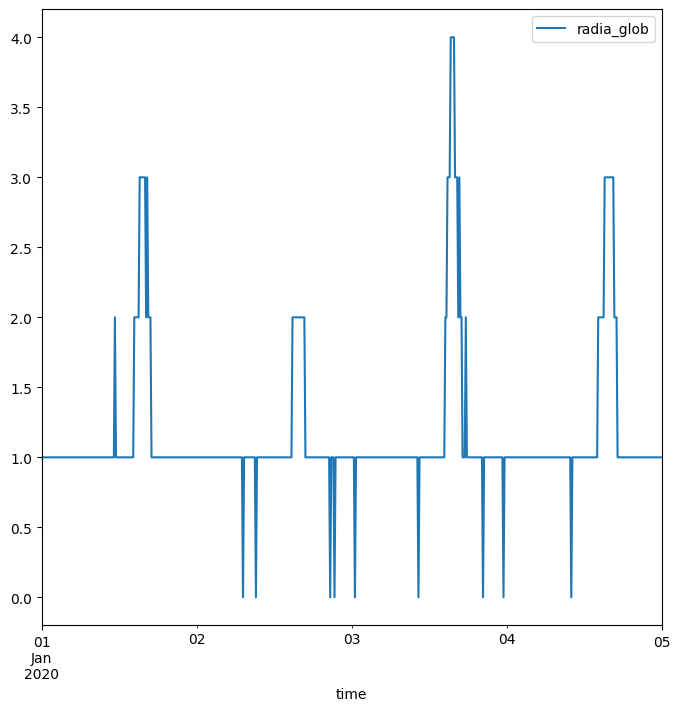

In [15]:
df.plot(figsize=(8, 8), sharex=True, subplots=True)